In [1]:
!git clone https://github.com/SCaRreC/Deep_learning.git


Cloning into 'Deep_learning'...
remote: Enumerating objects: 3087, done.
remote: Counting objects: 100% (3087/3087), done.
remote: Compressing objects: 100% (1534/1534), done.
remote: Total 3087 (delta 61), reused 3052 (delta 42), pack-reused 0 (from 0)
Receiving objects: 100% (3087/3087), 13.48 MiB | 17.41 MiB/s, done.
Resolving deltas: 100% (61/61), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Libraries and initial configuration

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import cv2
from torchvision import transforms
import os
import random
from PIL import Image
import torch

import sys
sys.path.insert(0, '/content/drive/MyDrive/Bootcamp/Deep_learning/src')
from utils import *

#from Deep_learning.src.utils import *
import joblib


In [4]:
# Data load
csv_path = os.path.join('Deep_learning', 'data', 'raw', 'poi_dataset.csv')
df_poi = pd.read_csv(csv_path)
# process raw data
df_poi_processed = data_processing(df_poi)
df_poi_processed.head(5).T

,0,1,2,3,4
tier,1,1,2,1,1
locationLon,2.642262,-3.704467,-3.699694,-3.691228,-3.727822
locationLat,39.572694,40.423037,40.442045,40.427256,40.439665
xps,500,500,250,500,500
main_image_path,Deep_learning/data/raw/data_main/4b36a3ed-3b28...,Deep_learning/data/raw/data_main/e32b3603-a94f...,Deep_learning/data/raw/data_main/0123a69b-13ac...,Deep_learning/data/raw/data_main/390d7d9e-e972...,Deep_learning/data/raw/data_main/023fc1bf-a1cd...
Arquitectura,0,0,0,0,0
Patrimonio,0,1,1,0,1
Historia,0,1,0,0,0
Ocio,0,0,0,0,0
Gastronomía,0,0,0,0,0


In [5]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


seed = 42
set_seed(seed)

# Division of Dataset

In [6]:
df_poi = df_poi_processed

In [7]:
from sklearn.model_selection import train_test_split

X = df_poi.drop(columns=['engagement', 'engagement_score'])
y = df_poi['engagement_score']

# Divide train and test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify= y,
    random_state = seed,
)
# Divide validation subset
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    stratify=y_train,
    random_state = seed,
)


In [8]:
print(type(y_train))
print(type(X_train))

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>


In [9]:
print("\nConteo absoluto en TRAIN:")
print(y_train.value_counts())

print("\nConteo absoluto en VALIDACIÓN:")
print(y_val.value_counts())

print("\nConteo absoluto en TEST:")
print(y_test.value_counts())



Conteo absoluto en TRAIN:
engagement_score
0    335
2    335
1    334
Name: count, dtype: int64

Conteo absoluto en VALIDACIÓN:
engagement_score
0    84
1    84
2    83
Name: count, dtype: int64

Conteo absoluto en TEST:
engagement_score
1    105
2    105
0    104
Name: count, dtype: int64


## Create the dataset custom


In [10]:
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from torchvision import transforms

In [11]:
# Transformations for images

#only for train
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transformations for validation and test
basic_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Diccionary
transforms_dict = {
    'train': train_transform,
    'val': basic_transform,
    'test': basic_transform
}

In [12]:
class ds_poi(Dataset):
  """
  Class that facilitates dataset processing to load it into de DataLoader.
  With different transforms for train, val, and test sets.
  it needs:
  - Initialize the dataset
  - get the length of the data set
  - obtain every item in the dataset
  """

  def __init__(self, target, features, image_path, transform=None, subset='train'):
    assert len(target) == len(image_path) == len(features)
    assert subset in ['train', 'val', 'test'], "subset must be 'train', 'val' or 'test'"
    # assert que target y features sean np.array o tensor
    self.target = torch.tensor(target, dtype=torch.long)
    #processed_features = process_features(features)
    self.features = torch.tensor(features, dtype=torch.float32)
    self.image_path = image_path
    self.transform = transform
    self.subset = subset

  def __len__(self):
    return len(self.features)


  def __getitem__(self, idx):
    target = self.target[idx]
    features = self.features[idx]
    im = cv2.imread(self.image_path[idx])
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = Image.fromarray(im)
    if self.transform is not None:
      if isinstance(self.transform, dict):
        im = self.transform[self.subset](im)
      else:
        im = self.transform(im)

    return target, features, im

In [13]:
# Reset indices before scaling and creating image path Series
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

#y_train = y_train.reset_index(drop=True)
#y_val = y_val.reset_index(drop=True)
#y_test = y_test.reset_index(drop=True)

# standarization
scaler, X_train_scaled = fit_transform_features(X_train.drop(columns=['main_image_path']))
X_val_scaled = transform_features(X_val.drop(columns=['main_image_path']), scaler)
X_test_scaled = transform_features(X_test.drop(columns=['main_image_path']), scaler)

# target

y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

# images
img_train = X_train['main_image_path']
img_val = X_val['main_image_path']
img_test = X_test['main_image_path']

# Ensure the image path Series also have reset indices
img_train = img_train.reset_index(drop=True)
img_val = img_val.reset_index(drop=True)
img_test = img_test.reset_index(drop=True)

print(X_train_scaled)
print(type(y_train))
print(type(img_train))

[[-0.85071917  0.99427137  1.01611293 ...  0.74120356 -0.10998534
  -1.63081285]
 [-0.85071917 -0.16684658  0.18691516 ...  0.74120356 -0.10998534
  -0.32512218]
 [ 0.70505869 -0.12071533  0.05811401 ...  0.74120356 -0.10998534
   0.32772316]
 ...
 [-0.85071917 -0.12125526  0.05868812 ... -1.34915704 -0.10998534
  -1.41319774]
 [-0.85071917 -0.12039985  0.05743463 ... -1.34915704 -0.10998534
   0.32772316]
 [ 0.70505869 -0.11935126  0.05979231 ...  0.74120356 -0.10998534
   0.98056849]]
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [14]:
# save all preprocessed data for modeling after.
"""
import joblib

os.makedirs('data/processed', exist_ok=True)

np.save('data/processed/X_train_scaled.npy', X_train_scaled)
np.save('data/processed/X_val_scaled.npy', X_val_scaled)
np.save('data/processed/X_test_scaled.npy', X_test_scaled)

np.save('data/processed/y_train.npy', y_train)
np.save('data/processed/y_val.npy', y_val)
np.save('data/processed/y_test.npy', y_test)

joblib.dump(img_train, 'data/processed/img_train.pkl')
joblib.dump(img_val, 'data/processed/img_val.pkl')
joblib.dump(img_test, 'data/processed/img_test.pkl')

joblib.dump(scaler, 'data/processed/scaler.pkl')
"""

"\nimport joblib\n\nos.makedirs('data/processed', exist_ok=True)\n\nnp.save('data/processed/X_train_scaled.npy', X_train_scaled)\nnp.save('data/processed/X_val_scaled.npy', X_val_scaled)\nnp.save('data/processed/X_test_scaled.npy', X_test_scaled)\n\nnp.save('data/processed/y_train.npy', y_train)\nnp.save('data/processed/y_val.npy', y_val)\nnp.save('data/processed/y_test.npy', y_test)\n\njoblib.dump(img_train, 'data/processed/img_train.pkl')\njoblib.dump(img_val, 'data/processed/img_val.pkl')\njoblib.dump(img_test, 'data/processed/img_test.pkl')\n\njoblib.dump(scaler, 'data/processed/scaler.pkl')\n"

In [15]:
#!zip -r processed_data.zip data/processed/
#from google.colab import files
#files.download('processed_data.zip')


In [16]:

# Datasets
train_dataset = ds_poi(
    y_train,
    X_train_scaled,
    img_train,
    transforms_dict,
    subset='train'
    )
val_dataset = ds_poi(y_val, X_val_scaled, img_val, transforms_dict, subset='val')
test_dataset = ds_poi(y_test, X_test_scaled, img_test, transforms_dict, subset='test')


In [17]:
batch_size = 32
num_features = X_train_scaled.shape[1]
num_classes = 3

In [18]:
# Create DataLoaders

generator = torch.Generator()
generator.manual_seed(seed)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator, worker_init_fn=lambda x: np.random.seed(seed))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, generator=generator, worker_init_fn=lambda x: np.random.seed(seed))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, generator=generator, worker_init_fn=lambda x: np.random.seed(seed))

## Sanity check

Targets shape: torch.Size([32])
Features shape: torch.Size([32, 17])
Images shape: torch.Size([32, 3, 128, 128])


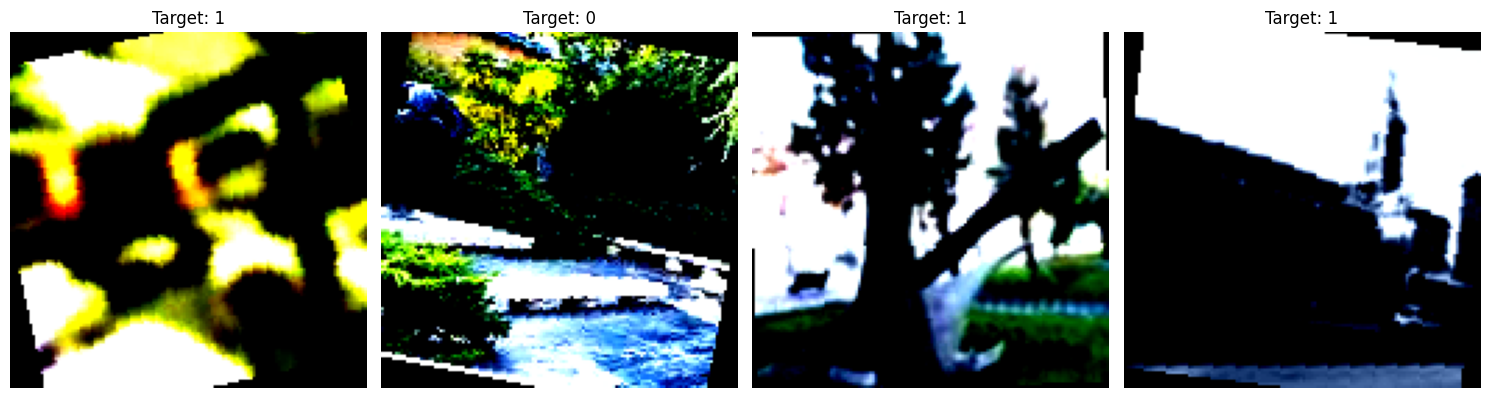

In [19]:
def show_sanity_batch(train_loader, class_labels=None):
    for batch in train_loader:
        targets, features, images = batch

        print("Targets shape:", targets.shape)
        print("Features shape:", features.shape)
        print("Images shape:", images.shape)

        # Mostrar las primeras 4 imágenes del batch
        images_np = images[:4].permute(0, 2, 3, 1).numpy()  # de [B, C, H, W] a [B, H, W, C]
        targets_np = targets[:4].numpy()

        fig, axs = plt.subplots(1, 4, figsize=(15, 5))
        for i in range(4):
            img = images[i].permute(1, 2, 0).numpy()  # De (C, H, W) a (H, W, C)
            axs[i].imshow(img)
            label = targets[i].item()
            axs[i].set_title(f'Target: {class_labels[label] if class_labels else label}')
            axs[i].axis('off')
        plt.tight_layout()
        plt.show()
        break  # Solo mostramos el primer batch

# Ejemplo de uso
show_sanity_batch(train_loader, class_labels=[0, 1, 2])

# Model

In [20]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models
import numpy as np
import torchvision
from PIL import Image
import pickle
import random

In [21]:

# hybrid model parametrizable
class HybridModel(nn.Module):
    def __init__(self, num_features, num_classes, trial, hidden_size=64, dropout=0.3, cnn_frozen=True):
        super(HybridModel, self).__init__()

        # ResNet18 without last layer
        self.cnn = torchvision.models.resnet18(pretrained=True)
        if cnn_frozen:
          for param in self.cnn.parameters():
              param.requires_grad = False  # freeze layers
        self.cnn_res = nn.Sequential(*list(self.cnn.children())[:-1])  # removes last layer (classificator)
        self.cnn_output_size = self.cnn.fc.in_features  # por ejemplo, 512

        # Features net
        self.feat = nn.Sequential(
            nn.Linear(num_features, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        # Classifier

        self.classifier = nn.Sequential(
            nn.Linear(self.cnn_output_size + hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, features, images):
        x_img = self.cnn_res(images)
        x_img = x_img.view(x_img.size(0), -1)
        x_feat = self.feat(features)
        x = torch.cat((x_img, x_feat), dim=1)
        out = self.classifier(x)
        return out


In [33]:
def objective(trial):
    """
    Función objetivo para la optimización de hiperparámetros con Optuna para el modelo híbrido.
    """
    print("\n" + "="*80)
    print(f"Iniciando Trial #{trial.number:03d}")
    print("="*80)

    # 1. Configuración inicial y semilla
    trial_seed = random.randint(1, 200)
    trial.set_user_attr("seed", trial_seed)
    print(f"\n🎲 Usando semilla: {trial_seed}")
    set_seed(trial_seed)

    # 2. Definir rangos de hiperparámetros
    hidden_size = trial.suggest_categorical("hidden_size", [32, 64, 128])
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64])



    print("\n📊 Hiperparámetros seleccionados:")
    print(f"   - Learning Rate: {lr:.6f}")
    print(f"   - Batch Size: {batch_size}")
    print(f"   - Hidden size: {hidden_size:.6f}")
    print(f"   - Dropout: {dropout:.6f}")

    # 3. Preparar datos
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator, worker_init_fn=lambda x: np.random.seed(seed))
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, generator=generator, worker_init_fn=lambda x: np.random.seed(seed))
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, generator=generator, worker_init_fn=lambda x: np.random.seed(seed))
    print("\n🔄 Datos preparados")

    # 4. Crear modelo
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = HybridModel(
        num_features=num_features,
        num_classes=num_classes,
        trial=trial,
        hidden_size=hidden_size,
        dropout=dropout
    ).to(device)

    print(f"🚀 Modelo creado y movido a {device}")
    #print(model)  # Opcional: Mostrar arquitectura del modelo

    # 5. Optimizador y pérdida
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # 6. Entrenamiento
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    print("\n📈 Iniciando entrenamiento:")
    print("-"*50)

    best_val_acc = 0.0
    patience = 5
    counter = 0

    for epoch in range(10):  # Aumenté a 20 épocas para modelos más complejos
        train_loss, train_acc = train_epoch(model, device, train_loader, criterion, optimizer)
        val_loss, val_acc = eval_epoch(model, device, val_loader, criterion)

        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            counter = 0
            # Guardar el mejor modelo
            torch.save(model.state_dict(), f"best_model_trial_{trial.number}.pt")
        else:
            counter += 1
            if counter >= patience:
                print(f"⚠️ Early stopping en época {epoch+1}")
                break

        print(f"Época {epoch+1:02d}: "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Acc: {val_acc:.2f}%")

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    # 7. Guardar métricas
    metrics = {
        "train_losses": train_losses,
        "train_accs": train_accs,
        "val_losses": val_losses,
        "val_accs": val_accs
    }

    with open(f"metrics_{trial.number}.pkl", "wb") as f:
        pickle.dump(metrics, f)

    trial.set_user_attr("metrics_path", f"metrics_{trial.number}.pkl")
    trial.set_user_attr("best_model_path", f"best_model_trial_{trial.number}.pt")

    # 8. Evaluación final
    model.load_state_dict(torch.load(f"best_model_trial_{trial.number}.pt"))
    test_acc = evaluate_model(model, test_loader, device)
    trial.set_user_attr("test_accuracy", test_acc)

    print(f"\n🎯 Mejor precisión en validación: {best_val_acc:.2f}%")
    print(f"🎯 Precisión en Test: {test_acc:.2f}%")
    print("\n✨ Trial completado ✨")
    print("="*80 + "\n")

    return best_val_acc

In [29]:
#!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 24.0 MB/s eta 0:00:00


In [34]:

import optuna
from optuna.samplers import TPESampler

# Configuración del estudio Optuna
study_name = "hybrid_model_optimization"
storage_url = "sqlite:///hybrid_model_study.sqlite3"

# Eliminamos el estudio si existe
try:
    optuna.delete_study(study_name=study_name, storage=storage_url)
except:
    pass

search_space = {
    "seed": [42],
    "dropout": [0.1, 0.5],
    "learning_rate": [1e-4, 1e-2],
    "hidden_size": [32, 64, 128],
    "batch_size": [32, 64],
}

# Creamos el estudio con TPE
study = optuna.create_study(study_name=study_name, direction="maximize", storage=storage_url,
                            sampler=TPESampler(seed=42), load_if_exists=False
)

# Número de trials (puedes ajustarlo según tus recursos)
n_trials = 20  # Menos que con GridSampler ya que TPE es más inteligente

print(f"🚀 Iniciando optimización con {n_trials} trials usando TPE...")

# Ejecutamos la optimización
study.optimize(objective, n_trials=n_trials)

print("✅ Optimización completada!")
# Imprimimos los mejores resultados
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Visualizamos la importancia de los parámetros
optuna.visualization.plot_param_importances(study)



[I 2025-06-10 09:44:06,803] A new study created in RDB with name: hybrid_model_optimization
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🚀 Iniciando optimización con 20 trials usando TPE...

Iniciando Trial #000

🎲 Usando semilla: 97

📊 Hiperparámetros seleccionados:
   - Learning Rate: 0.000205
   - Batch Size: 32
   - Hidden size: 64.000000
   - Dropout: 0.339463

🔄 Datos preparados


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 215MB/s]


🚀 Modelo creado y movido a cuda

📈 Iniciando entrenamiento:
--------------------------------------------------
Época 01: Train Loss: 1.0804, Train Acc: 41.14%, Val Loss: 1.0189, Val Acc: 53.78%
Época 02: Train Loss: 0.9790, Train Acc: 55.98%, Val Loss: 0.9284, Val Acc: 64.94%
Época 03: Train Loss: 0.8907, Train Acc: 61.35%, Val Loss: 0.8272, Val Acc: 70.12%
Época 04: Train Loss: 0.8078, Train Acc: 68.13%, Val Loss: 0.7651, Val Acc: 72.11%
Época 05: Train Loss: 0.7408, Train Acc: 69.82%, Val Loss: 0.7198, Val Acc: 73.31%
Época 06: Train Loss: 0.7019, Train Acc: 71.91%, Val Loss: 0.6764, Val Acc: 75.30%
Época 07: Train Loss: 0.6593, Train Acc: 73.21%, Val Loss: 0.6350, Val Acc: 76.49%
Época 08: Train Loss: 0.6277, Train Acc: 74.80%, Val Loss: 0.6000, Val Acc: 78.49%
Época 09: Train Loss: 0.5805, Train Acc: 77.49%, Val Loss: 0.5841, Val Acc: 77.29%
Época 10: Train Loss: 0.5816, Train Acc: 76.89%, Val Loss: 0.5541, Val Acc: 78.49%


[I 2025-06-10 09:44:36,288] Trial 0 finished with value: 78.48605577689243 and parameters: {'hidden_size': 64, 'dropout': 0.3394633936788146, 'lr': 0.0002051338263087451, 'batch_size': 32}. Best is trial 0 with value: 78.48605577689243.



🎯 Mejor precisión en validación: 78.49%
🎯 Precisión en Test: 77.39%

✨ Trial completado ✨


Iniciando Trial #001

🎲 Usando semilla: 50

📊 Hiperparámetros seleccionados:
   - Learning Rate: 0.008706
   - Batch Size: 32
   - Hidden size: 32.000000
   - Dropout: 0.108234

🔄 Datos preparados
🚀 Modelo creado y movido a cuda

📈 Iniciando entrenamiento:
--------------------------------------------------
Época 01: Train Loss: 1.0562, Train Acc: 43.63%, Val Loss: 0.7522, Val Acc: 68.92%
Época 02: Train Loss: 0.6688, Train Acc: 71.22%, Val Loss: 0.5047, Val Acc: 78.88%
Época 03: Train Loss: 0.5448, Train Acc: 76.89%, Val Loss: 0.4801, Val Acc: 78.09%
Época 04: Train Loss: 0.5457, Train Acc: 74.90%, Val Loss: 0.4554, Val Acc: 78.88%
Época 05: Train Loss: 0.5162, Train Acc: 78.29%, Val Loss: 0.4645, Val Acc: 76.89%
Época 06: Train Loss: 0.5329, Train Acc: 76.39%, Val Loss: 0.4701, Val Acc: 77.29%
Época 07: Train Loss: 0.5269, Train Acc: 76.29%, Val Loss: 0.4523, Val Acc: 79.68%
Época 08: Train Lo

[I 2025-06-10 09:45:03,413] Trial 1 finished with value: 81.27490039840637 and parameters: {'hidden_size': 32, 'dropout': 0.10823379771832098, 'lr': 0.008706020878304856, 'batch_size': 32}. Best is trial 1 with value: 81.27490039840637.



🎯 Mejor precisión en validación: 81.27%
🎯 Precisión en Test: 77.71%

✨ Trial completado ✨


Iniciando Trial #002

🎲 Usando semilla: 128

📊 Hiperparámetros seleccionados:
   - Learning Rate: 0.000731
   - Batch Size: 64
   - Hidden size: 128.000000
   - Dropout: 0.309903

🔄 Datos preparados
🚀 Modelo creado y movido a cuda

📈 Iniciando entrenamiento:
--------------------------------------------------
Época 01: Train Loss: 0.9973, Train Acc: 52.09%, Val Loss: 0.8613, Val Acc: 70.52%
Época 02: Train Loss: 0.7478, Train Acc: 69.72%, Val Loss: 0.6843, Val Acc: 72.91%
Época 03: Train Loss: 0.6316, Train Acc: 74.30%, Val Loss: 0.5680, Val Acc: 77.69%
Época 04: Train Loss: 0.5577, Train Acc: 76.89%, Val Loss: 0.5168, Val Acc: 78.88%
Época 05: Train Loss: 0.5061, Train Acc: 79.78%, Val Loss: 0.4861, Val Acc: 80.08%
Época 06: Train Loss: 0.4761, Train Acc: 80.88%, Val Loss: 0.5406, Val Acc: 77.29%
Época 07: Train Loss: 0.4742, Train Acc: 80.78%, Val Loss: 0.4597, Val Acc: 78.49%
Época 08: Train 

[I 2025-06-10 09:45:29,933] Trial 2 finished with value: 80.0796812749004 and parameters: {'hidden_size': 128, 'dropout': 0.3099025726528951, 'lr': 0.0007309539835912913, 'batch_size': 64}. Best is trial 1 with value: 81.27490039840637.



🎯 Mejor precisión en validación: 80.08%
🎯 Precisión en Test: 78.03%

✨ Trial completado ✨


Iniciando Trial #003

🎲 Usando semilla: 61

📊 Hiperparámetros seleccionados:
   - Learning Rate: 0.003718
   - Batch Size: 64
   - Hidden size: 128.000000
   - Dropout: 0.282428

🔄 Datos preparados
🚀 Modelo creado y movido a cuda

📈 Iniciando entrenamiento:
--------------------------------------------------
Época 01: Train Loss: 1.0746, Train Acc: 48.80%, Val Loss: 0.7324, Val Acc: 70.12%
Época 02: Train Loss: 0.6577, Train Acc: 70.92%, Val Loss: 0.5398, Val Acc: 75.70%
Época 03: Train Loss: 0.5362, Train Acc: 77.79%, Val Loss: 0.4675, Val Acc: 80.08%
Época 04: Train Loss: 0.4999, Train Acc: 80.18%, Val Loss: 0.4746, Val Acc: 80.08%
Época 05: Train Loss: 0.4653, Train Acc: 79.38%, Val Loss: 0.4403, Val Acc: 80.88%
Época 06: Train Loss: 0.4396, Train Acc: 82.27%, Val Loss: 0.4554, Val Acc: 78.49%
Época 07: Train Loss: 0.4341, Train Acc: 83.07%, Val Loss: 0.4425, Val Acc: 80.08%
Época 08: Train L

[I 2025-06-10 09:45:56,630] Trial 3 finished with value: 82.07171314741036 and parameters: {'hidden_size': 128, 'dropout': 0.28242799368681437, 'lr': 0.0037183641805732083, 'batch_size': 64}. Best is trial 3 with value: 82.07171314741036.



🎯 Mejor precisión en validación: 82.07%
🎯 Precisión en Test: 77.71%

✨ Trial completado ✨


Iniciando Trial #004

🎲 Usando semilla: 127

📊 Hiperparámetros seleccionados:
   - Learning Rate: 0.000135
   - Batch Size: 64
   - Hidden size: 128.000000
   - Dropout: 0.168210

🔄 Datos preparados
🚀 Modelo creado y movido a cuda

📈 Iniciando entrenamiento:
--------------------------------------------------
Época 01: Train Loss: 1.0809, Train Acc: 42.23%, Val Loss: 1.0273, Val Acc: 52.19%
Época 02: Train Loss: 0.9937, Train Acc: 56.47%, Val Loss: 0.9504, Val Acc: 67.73%
Época 03: Train Loss: 0.9046, Train Acc: 66.14%, Val Loss: 0.8720, Val Acc: 71.31%
Época 04: Train Loss: 0.8182, Train Acc: 71.71%, Val Loss: 0.8000, Val Acc: 74.50%
Época 05: Train Loss: 0.7620, Train Acc: 72.81%, Val Loss: 0.7340, Val Acc: 78.09%
Época 06: Train Loss: 0.6902, Train Acc: 75.40%, Val Loss: 0.6895, Val Acc: 77.69%
Época 07: Train Loss: 0.6549, Train Acc: 75.50%, Val Loss: 0.6573, Val Acc: 75.70%
Época 08: Train 

[I 2025-06-10 09:46:23,496] Trial 4 finished with value: 81.67330677290836 and parameters: {'hidden_size': 128, 'dropout': 0.16820964947491662, 'lr': 0.00013492834268013249, 'batch_size': 64}. Best is trial 3 with value: 82.07171314741036.



🎯 Mejor precisión en validación: 81.67%
🎯 Precisión en Test: 77.39%

✨ Trial completado ✨


Iniciando Trial #005

🎲 Usando semilla: 12

📊 Hiperparámetros seleccionados:
   - Learning Rate: 0.000759
   - Batch Size: 64
   - Hidden size: 32.000000
   - Dropout: 0.373693

🔄 Datos preparados
🚀 Modelo creado y movido a cuda

📈 Iniciando entrenamiento:
--------------------------------------------------
Época 01: Train Loss: 1.0614, Train Acc: 42.33%, Val Loss: 0.9765, Val Acc: 58.57%
Época 02: Train Loss: 0.9596, Train Acc: 54.38%, Val Loss: 0.9132, Val Acc: 57.77%
Época 03: Train Loss: 0.8840, Train Acc: 58.76%, Val Loss: 0.8113, Val Acc: 66.14%
Época 04: Train Loss: 0.8006, Train Acc: 63.25%, Val Loss: 0.7510, Val Acc: 68.92%
Época 05: Train Loss: 0.7338, Train Acc: 68.43%, Val Loss: 0.6824, Val Acc: 72.51%
Época 06: Train Loss: 0.6794, Train Acc: 72.11%, Val Loss: 0.6349, Val Acc: 74.90%
Época 07: Train Loss: 0.6497, Train Acc: 73.51%, Val Loss: 0.6023, Val Acc: 74.90%
Época 08: Train Lo

[I 2025-06-10 09:46:50,741] Trial 5 finished with value: 80.0796812749004 and parameters: {'hidden_size': 32, 'dropout': 0.3736932106048628, 'lr': 0.0007591104805282694, 'batch_size': 64}. Best is trial 3 with value: 82.07171314741036.



🎯 Mejor precisión en validación: 80.08%
🎯 Precisión en Test: 78.03%

✨ Trial completado ✨


Iniciando Trial #006

🎲 Usando semilla: 122

📊 Hiperparámetros seleccionados:
   - Learning Rate: 0.000420
   - Batch Size: 64
   - Hidden size: 64.000000
   - Dropout: 0.365009

🔄 Datos preparados
🚀 Modelo creado y movido a cuda

📈 Iniciando entrenamiento:
--------------------------------------------------
Época 01: Train Loss: 1.0855, Train Acc: 39.74%, Val Loss: 0.9971, Val Acc: 55.38%
Época 02: Train Loss: 0.9699, Train Acc: 54.68%, Val Loss: 0.8968, Val Acc: 62.95%
Época 03: Train Loss: 0.8583, Train Acc: 63.05%, Val Loss: 0.8245, Val Acc: 65.34%
Época 04: Train Loss: 0.8165, Train Acc: 65.84%, Val Loss: 0.7569, Val Acc: 68.92%
Época 05: Train Loss: 0.7084, Train Acc: 71.71%, Val Loss: 0.7032, Val Acc: 69.72%
Época 06: Train Loss: 0.6965, Train Acc: 72.61%, Val Loss: 0.6685, Val Acc: 69.32%
Época 07: Train Loss: 0.6212, Train Acc: 75.90%, Val Loss: 0.6563, Val Acc: 72.91%
Época 08: Train L

[I 2025-06-10 09:47:17,615] Trial 6 finished with value: 78.88446215139442 and parameters: {'hidden_size': 64, 'dropout': 0.36500891374159283, 'lr': 0.0004201672054372534, 'batch_size': 64}. Best is trial 3 with value: 82.07171314741036.



🎯 Mejor precisión en validación: 78.88%
🎯 Precisión en Test: 76.75%

✨ Trial completado ✨


Iniciando Trial #007

🎲 Usando semilla: 131

📊 Hiperparámetros seleccionados:
   - Learning Rate: 0.006161
   - Batch Size: 64
   - Hidden size: 64.000000
   - Dropout: 0.475800

🔄 Datos preparados
🚀 Modelo creado y movido a cuda

📈 Iniciando entrenamiento:
--------------------------------------------------
Época 01: Train Loss: 1.1998, Train Acc: 42.03%, Val Loss: 0.9217, Val Acc: 60.16%
Época 02: Train Loss: 0.8381, Train Acc: 61.16%, Val Loss: 0.6310, Val Acc: 74.50%
Época 03: Train Loss: 0.6544, Train Acc: 70.72%, Val Loss: 0.4899, Val Acc: 79.68%
Época 04: Train Loss: 0.5869, Train Acc: 72.61%, Val Loss: 0.4611, Val Acc: 81.67%
Época 05: Train Loss: 0.5684, Train Acc: 76.79%, Val Loss: 0.4619, Val Acc: 81.27%
Época 06: Train Loss: 0.5383, Train Acc: 76.89%, Val Loss: 0.4820, Val Acc: 77.69%
Época 07: Train Loss: 0.5510, Train Acc: 75.80%, Val Loss: 0.4431, Val Acc: 79.68%
Época 08: Train L

[I 2025-06-10 09:47:41,690] Trial 7 finished with value: 81.67330677290836 and parameters: {'hidden_size': 64, 'dropout': 0.4757995766256756, 'lr': 0.006161049539380964, 'batch_size': 64}. Best is trial 3 with value: 82.07171314741036.



🎯 Mejor precisión en validación: 81.67%
🎯 Precisión en Test: 79.62%

✨ Trial completado ✨


Iniciando Trial #008

🎲 Usando semilla: 81

📊 Hiperparámetros seleccionados:
   - Learning Rate: 0.000599
   - Batch Size: 64
   - Hidden size: 64.000000
   - Dropout: 0.230132

🔄 Datos preparados
🚀 Modelo creado y movido a cuda

📈 Iniciando entrenamiento:
--------------------------------------------------
Época 01: Train Loss: 1.0300, Train Acc: 47.01%, Val Loss: 0.9662, Val Acc: 55.38%
Época 02: Train Loss: 0.8823, Train Acc: 63.05%, Val Loss: 0.8401, Val Acc: 64.14%
Época 03: Train Loss: 0.7823, Train Acc: 68.13%, Val Loss: 0.7777, Val Acc: 67.33%
Época 04: Train Loss: 0.6985, Train Acc: 70.82%, Val Loss: 0.6850, Val Acc: 72.51%
Época 05: Train Loss: 0.6216, Train Acc: 74.30%, Val Loss: 0.6115, Val Acc: 74.10%
Época 06: Train Loss: 0.5995, Train Acc: 75.50%, Val Loss: 0.5730, Val Acc: 77.29%
Época 07: Train Loss: 0.5452, Train Acc: 77.99%, Val Loss: 0.5628, Val Acc: 75.70%
Época 08: Train Lo

[I 2025-06-10 09:48:08,467] Trial 8 finished with value: 80.87649402390439 and parameters: {'hidden_size': 64, 'dropout': 0.23013213230530574, 'lr': 0.0005989003672254305, 'batch_size': 64}. Best is trial 3 with value: 82.07171314741036.



🎯 Mejor precisión en validación: 80.88%
🎯 Precisión en Test: 79.30%

✨ Trial completado ✨


Iniciando Trial #009

🎲 Usando semilla: 130

📊 Hiperparámetros seleccionados:
   - Learning Rate: 0.004022
   - Batch Size: 64
   - Hidden size: 128.000000
   - Dropout: 0.156370

🔄 Datos preparados
🚀 Modelo creado y movido a cuda

📈 Iniciando entrenamiento:
--------------------------------------------------
Época 01: Train Loss: 0.9109, Train Acc: 57.77%, Val Loss: 0.5672, Val Acc: 78.09%
Época 02: Train Loss: 0.5901, Train Acc: 75.90%, Val Loss: 0.4950, Val Acc: 79.68%
Época 03: Train Loss: 0.4846, Train Acc: 81.77%, Val Loss: 0.4688, Val Acc: 80.08%
Época 04: Train Loss: 0.4661, Train Acc: 80.48%, Val Loss: 0.5044, Val Acc: 74.50%
Época 05: Train Loss: 0.4351, Train Acc: 80.88%, Val Loss: 0.4370, Val Acc: 81.27%
Época 06: Train Loss: 0.4172, Train Acc: 81.97%, Val Loss: 0.4245, Val Acc: 81.67%
Época 07: Train Loss: 0.3958, Train Acc: 81.18%, Val Loss: 0.4803, Val Acc: 77.29%
Época 08: Train 

[I 2025-06-10 09:48:35,021] Trial 9 finished with value: 81.67330677290836 and parameters: {'hidden_size': 128, 'dropout': 0.15636968998990508, 'lr': 0.0040215545266902904, 'batch_size': 64}. Best is trial 3 with value: 82.07171314741036.



🎯 Mejor precisión en validación: 81.67%
🎯 Precisión en Test: 78.66%

✨ Trial completado ✨


Iniciando Trial #010

🎲 Usando semilla: 134

📊 Hiperparámetros seleccionados:
   - Learning Rate: 0.002352
   - Batch Size: 32
   - Hidden size: 128.000000
   - Dropout: 0.245491

🔄 Datos preparados
🚀 Modelo creado y movido a cuda

📈 Iniciando entrenamiento:
--------------------------------------------------
Época 01: Train Loss: 0.8020, Train Acc: 61.85%, Val Loss: 0.5394, Val Acc: 78.49%
Época 02: Train Loss: 0.5197, Train Acc: 78.69%, Val Loss: 0.4500, Val Acc: 81.27%
Época 03: Train Loss: 0.5167, Train Acc: 77.99%, Val Loss: 0.4586, Val Acc: 80.48%
Época 04: Train Loss: 0.4537, Train Acc: 81.87%, Val Loss: 0.4682, Val Acc: 78.49%
Época 05: Train Loss: 0.4742, Train Acc: 81.37%, Val Loss: 0.4362, Val Acc: 80.48%
Época 06: Train Loss: 0.4357, Train Acc: 81.97%, Val Loss: 0.4217, Val Acc: 82.07%
Época 07: Train Loss: 0.4256, Train Acc: 82.97%, Val Loss: 0.4329, Val Acc: 80.08%
Época 08: Train 

[I 2025-06-10 09:49:02,683] Trial 10 finished with value: 82.07171314741036 and parameters: {'hidden_size': 128, 'dropout': 0.24549106944865245, 'lr': 0.0023515708552063496, 'batch_size': 32}. Best is trial 3 with value: 82.07171314741036.



🎯 Mejor precisión en validación: 82.07%
🎯 Precisión en Test: 77.39%

✨ Trial completado ✨


Iniciando Trial #011

🎲 Usando semilla: 124

📊 Hiperparámetros seleccionados:
   - Learning Rate: 0.002337
   - Batch Size: 32
   - Hidden size: 128.000000
   - Dropout: 0.250824

🔄 Datos preparados
🚀 Modelo creado y movido a cuda

📈 Iniciando entrenamiento:
--------------------------------------------------
Época 01: Train Loss: 0.7825, Train Acc: 63.94%, Val Loss: 0.6304, Val Acc: 69.32%
Época 02: Train Loss: 0.5528, Train Acc: 77.39%, Val Loss: 0.5508, Val Acc: 74.10%
Época 03: Train Loss: 0.4945, Train Acc: 79.68%, Val Loss: 0.4466, Val Acc: 79.68%
Época 04: Train Loss: 0.4505, Train Acc: 80.98%, Val Loss: 0.4580, Val Acc: 79.28%
Época 05: Train Loss: 0.4462, Train Acc: 81.08%, Val Loss: 0.4516, Val Acc: 81.27%
Época 06: Train Loss: 0.4313, Train Acc: 80.78%, Val Loss: 0.4425, Val Acc: 80.08%
Época 07: Train Loss: 0.4481, Train Acc: 80.38%, Val Loss: 0.4007, Val Acc: 81.67%
Época 08: Train 

[I 2025-06-10 09:49:30,156] Trial 11 finished with value: 81.67330677290836 and parameters: {'hidden_size': 128, 'dropout': 0.2508243465834928, 'lr': 0.0023372180232778183, 'batch_size': 32}. Best is trial 3 with value: 82.07171314741036.



🎯 Mejor precisión en validación: 81.67%
🎯 Precisión en Test: 78.98%

✨ Trial completado ✨


Iniciando Trial #012

🎲 Usando semilla: 72

📊 Hiperparámetros seleccionados:
   - Learning Rate: 0.002057
   - Batch Size: 32
   - Hidden size: 128.000000
   - Dropout: 0.251842

🔄 Datos preparados
🚀 Modelo creado y movido a cuda

📈 Iniciando entrenamiento:
--------------------------------------------------
Época 01: Train Loss: 0.8434, Train Acc: 59.96%, Val Loss: 0.6026, Val Acc: 75.30%
Época 02: Train Loss: 0.5698, Train Acc: 76.20%, Val Loss: 0.4664, Val Acc: 81.67%
Época 03: Train Loss: 0.4709, Train Acc: 82.17%, Val Loss: 0.4708, Val Acc: 80.08%
Época 04: Train Loss: 0.5071, Train Acc: 79.18%, Val Loss: 0.4459, Val Acc: 79.28%
Época 05: Train Loss: 0.4899, Train Acc: 80.68%, Val Loss: 0.4438, Val Acc: 80.88%
Época 06: Train Loss: 0.4602, Train Acc: 81.97%, Val Loss: 0.4211, Val Acc: 80.88%
⚠️ Early stopping en época 7


[I 2025-06-10 09:49:49,963] Trial 12 finished with value: 81.67330677290836 and parameters: {'hidden_size': 128, 'dropout': 0.2518416973680894, 'lr': 0.0020570092769171236, 'batch_size': 32}. Best is trial 3 with value: 82.07171314741036.



🎯 Mejor precisión en validación: 81.67%
🎯 Precisión en Test: 77.71%

✨ Trial completado ✨


Iniciando Trial #013

🎲 Usando semilla: 19

📊 Hiperparámetros seleccionados:
   - Learning Rate: 0.001773
   - Batch Size: 32
   - Hidden size: 128.000000
   - Dropout: 0.456216

🔄 Datos preparados
🚀 Modelo creado y movido a cuda

📈 Iniciando entrenamiento:
--------------------------------------------------
Época 01: Train Loss: 0.9474, Train Acc: 53.39%, Val Loss: 0.6524, Val Acc: 72.51%
Época 02: Train Loss: 0.6552, Train Acc: 71.61%, Val Loss: 0.5277, Val Acc: 79.28%
Época 03: Train Loss: 0.5721, Train Acc: 77.19%, Val Loss: 0.4756, Val Acc: 80.88%
Época 04: Train Loss: 0.5084, Train Acc: 79.18%, Val Loss: 0.4361, Val Acc: 80.08%
Época 05: Train Loss: 0.5241, Train Acc: 78.49%, Val Loss: 0.4645, Val Acc: 80.08%
Época 06: Train Loss: 0.4818, Train Acc: 82.37%, Val Loss: 0.4247, Val Acc: 79.28%
Época 07: Train Loss: 0.4576, Train Acc: 80.78%, Val Loss: 0.4277, Val Acc: 79.68%
⚠️ Early stopping

[I 2025-06-10 09:50:11,500] Trial 13 finished with value: 80.87649402390439 and parameters: {'hidden_size': 128, 'dropout': 0.45621601194762, 'lr': 0.0017731145679319238, 'batch_size': 32}. Best is trial 3 with value: 82.07171314741036.



🎯 Mejor precisión en validación: 80.88%
🎯 Precisión en Test: 77.39%

✨ Trial completado ✨


Iniciando Trial #014

🎲 Usando semilla: 174

📊 Hiperparámetros seleccionados:
   - Learning Rate: 0.003406
   - Batch Size: 32
   - Hidden size: 128.000000
   - Dropout: 0.208271

🔄 Datos preparados
🚀 Modelo creado y movido a cuda

📈 Iniciando entrenamiento:
--------------------------------------------------
Época 01: Train Loss: 0.8310, Train Acc: 62.25%, Val Loss: 0.5117, Val Acc: 78.88%
Época 02: Train Loss: 0.5532, Train Acc: 78.09%, Val Loss: 0.5125, Val Acc: 74.10%
Época 03: Train Loss: 0.5101, Train Acc: 77.79%, Val Loss: 0.4372, Val Acc: 81.27%
Época 04: Train Loss: 0.4832, Train Acc: 79.88%, Val Loss: 0.4415, Val Acc: 81.27%
Época 05: Train Loss: 0.4532, Train Acc: 81.87%, Val Loss: 0.5027, Val Acc: 75.30%
Época 06: Train Loss: 0.4391, Train Acc: 80.88%, Val Loss: 0.4163, Val Acc: 80.48%
Época 07: Train Loss: 0.4058, Train Acc: 83.57%, Val Loss: 0.4204, Val Acc: 81.67%
Época 08: Train 

[I 2025-06-10 09:50:38,848] Trial 14 finished with value: 82.07171314741036 and parameters: {'hidden_size': 128, 'dropout': 0.2082713029686754, 'lr': 0.0034062365031735328, 'batch_size': 32}. Best is trial 3 with value: 82.07171314741036.



🎯 Mejor precisión en validación: 82.07%
🎯 Precisión en Test: 77.39%

✨ Trial completado ✨


Iniciando Trial #015

🎲 Usando semilla: 2

📊 Hiperparámetros seleccionados:
   - Learning Rate: 0.001332
   - Batch Size: 32
   - Hidden size: 128.000000
   - Dropout: 0.294286

🔄 Datos preparados
🚀 Modelo creado y movido a cuda

📈 Iniciando entrenamiento:
--------------------------------------------------
Época 01: Train Loss: 0.8709, Train Acc: 58.86%, Val Loss: 0.6633, Val Acc: 72.51%
Época 02: Train Loss: 0.6198, Train Acc: 74.90%, Val Loss: 0.5240, Val Acc: 78.49%
Época 03: Train Loss: 0.5034, Train Acc: 79.08%, Val Loss: 0.4614, Val Acc: 78.88%
Época 04: Train Loss: 0.4845, Train Acc: 80.58%, Val Loss: 0.4630, Val Acc: 78.88%
Época 05: Train Loss: 0.5077, Train Acc: 78.78%, Val Loss: 0.4336, Val Acc: 82.07%
Época 06: Train Loss: 0.4298, Train Acc: 82.57%, Val Loss: 0.4501, Val Acc: 80.08%
Época 07: Train Loss: 0.4488, Train Acc: 82.27%, Val Loss: 0.4187, Val Acc: 81.27%
Época 08: Train Lo

[I 2025-06-10 09:51:06,136] Trial 15 finished with value: 82.07171314741036 and parameters: {'hidden_size': 128, 'dropout': 0.29428595993612194, 'lr': 0.00133222299177542, 'batch_size': 32}. Best is trial 3 with value: 82.07171314741036.



🎯 Mejor precisión en validación: 82.07%
🎯 Precisión en Test: 76.75%

✨ Trial completado ✨


Iniciando Trial #016

🎲 Usando semilla: 15

📊 Hiperparámetros seleccionados:
   - Learning Rate: 0.004363
   - Batch Size: 64
   - Hidden size: 32.000000
   - Dropout: 0.407476

🔄 Datos preparados
🚀 Modelo creado y movido a cuda

📈 Iniciando entrenamiento:
--------------------------------------------------
Época 01: Train Loss: 1.0765, Train Acc: 40.74%, Val Loss: 0.9959, Val Acc: 51.39%
Época 02: Train Loss: 0.9408, Train Acc: 55.08%, Val Loss: 0.9116, Val Acc: 59.36%
Época 03: Train Loss: 0.8542, Train Acc: 59.46%, Val Loss: 0.7727, Val Acc: 68.13%
Época 04: Train Loss: 0.7382, Train Acc: 66.53%, Val Loss: 0.6135, Val Acc: 76.10%
Época 05: Train Loss: 0.6274, Train Acc: 70.62%, Val Loss: 0.4982, Val Acc: 81.27%
Época 06: Train Loss: 0.6331, Train Acc: 69.72%, Val Loss: 0.5195, Val Acc: 76.89%
Época 07: Train Loss: 0.6168, Train Acc: 67.63%, Val Loss: 0.4829, Val Acc: 80.88%
Época 08: Train Lo

[I 2025-06-10 09:51:32,738] Trial 16 finished with value: 82.07171314741036 and parameters: {'hidden_size': 32, 'dropout': 0.407475950418773, 'lr': 0.004362970937949069, 'batch_size': 64}. Best is trial 3 with value: 82.07171314741036.



🎯 Mejor precisión en validación: 82.07%
🎯 Precisión en Test: 77.71%

✨ Trial completado ✨


Iniciando Trial #017

🎲 Usando semilla: 54

📊 Hiperparámetros seleccionados:
   - Learning Rate: 0.009971
   - Batch Size: 32
   - Hidden size: 128.000000
   - Dropout: 0.287261

🔄 Datos preparados
🚀 Modelo creado y movido a cuda

📈 Iniciando entrenamiento:
--------------------------------------------------
Época 01: Train Loss: 1.1973, Train Acc: 48.71%, Val Loss: 0.5409, Val Acc: 77.29%
Época 02: Train Loss: 0.6333, Train Acc: 71.22%, Val Loss: 0.5951, Val Acc: 68.53%
Época 03: Train Loss: 0.5803, Train Acc: 72.61%, Val Loss: 0.4900, Val Acc: 80.08%
Época 04: Train Loss: 0.5380, Train Acc: 75.90%, Val Loss: 0.4528, Val Acc: 77.29%
Época 05: Train Loss: 0.5287, Train Acc: 72.71%, Val Loss: 0.4644, Val Acc: 80.88%
Época 06: Train Loss: 0.5352, Train Acc: 75.80%, Val Loss: 0.4649, Val Acc: 80.48%
Época 07: Train Loss: 0.5618, Train Acc: 74.00%, Val Loss: 0.4667, Val Acc: 80.08%
Época 08: Train L

[I 2025-06-10 09:52:00,004] Trial 17 finished with value: 80.87649402390439 and parameters: {'hidden_size': 128, 'dropout': 0.28726134717464824, 'lr': 0.009970682275036448, 'batch_size': 32}. Best is trial 3 with value: 82.07171314741036.



🎯 Mejor precisión en validación: 80.88%
🎯 Precisión en Test: 77.39%

✨ Trial completado ✨


Iniciando Trial #018

🎲 Usando semilla: 36

📊 Hiperparámetros seleccionados:
   - Learning Rate: 0.002908
   - Batch Size: 32
   - Hidden size: 128.000000
   - Dropout: 0.196622

🔄 Datos preparados
🚀 Modelo creado y movido a cuda

📈 Iniciando entrenamiento:
--------------------------------------------------
Época 01: Train Loss: 0.8878, Train Acc: 58.76%, Val Loss: 0.5656, Val Acc: 73.31%
Época 02: Train Loss: 0.5504, Train Acc: 77.39%, Val Loss: 0.5585, Val Acc: 74.10%
Época 03: Train Loss: 0.4983, Train Acc: 80.28%, Val Loss: 0.4798, Val Acc: 78.09%
Época 04: Train Loss: 0.4646, Train Acc: 79.28%, Val Loss: 0.5250, Val Acc: 74.90%
Época 05: Train Loss: 0.4714, Train Acc: 80.78%, Val Loss: 0.4282, Val Acc: 79.28%
Época 06: Train Loss: 0.4402, Train Acc: 81.08%, Val Loss: 0.4676, Val Acc: 78.49%
Época 07: Train Loss: 0.4801, Train Acc: 79.38%, Val Loss: 0.4387, Val Acc: 77.69%
Época 08: Train L

[I 2025-06-10 09:52:27,966] Trial 18 finished with value: 83.26693227091633 and parameters: {'hidden_size': 128, 'dropout': 0.19662197319213595, 'lr': 0.0029081869788497995, 'batch_size': 32}. Best is trial 18 with value: 83.26693227091633.



🎯 Mejor precisión en validación: 83.27%
🎯 Precisión en Test: 79.62%

✨ Trial completado ✨


Iniciando Trial #019

🎲 Usando semilla: 85

📊 Hiperparámetros seleccionados:
   - Learning Rate: 0.001185
   - Batch Size: 64
   - Hidden size: 32.000000
   - Dropout: 0.185455

🔄 Datos preparados
🚀 Modelo creado y movido a cuda

📈 Iniciando entrenamiento:
--------------------------------------------------
Época 01: Train Loss: 1.0615, Train Acc: 42.73%, Val Loss: 0.9832, Val Acc: 54.98%
Época 02: Train Loss: 0.8980, Train Acc: 58.47%, Val Loss: 0.8287, Val Acc: 63.75%
Época 03: Train Loss: 0.7610, Train Acc: 68.03%, Val Loss: 0.7232, Val Acc: 72.11%
Época 04: Train Loss: 0.6809, Train Acc: 71.81%, Val Loss: 0.6535, Val Acc: 73.31%
Época 05: Train Loss: 0.6148, Train Acc: 75.40%, Val Loss: 0.5848, Val Acc: 76.49%
Época 06: Train Loss: 0.5542, Train Acc: 76.59%, Val Loss: 0.5528, Val Acc: 76.89%
Época 07: Train Loss: 0.5140, Train Acc: 78.59%, Val Loss: 0.4872, Val Acc: 81.67%
Época 08: Train Lo

[I 2025-06-10 09:52:54,647] Trial 19 finished with value: 81.67330677290836 and parameters: {'hidden_size': 32, 'dropout': 0.18545507422756713, 'lr': 0.0011851274890350629, 'batch_size': 64}. Best is trial 18 with value: 83.26693227091633.



🎯 Mejor precisión en validación: 81.67%
🎯 Precisión en Test: 77.71%

✨ Trial completado ✨

✅ Optimización completada!
Best trial:
  Value:  83.26693227091633
  Params: 
    hidden_size: 128
    dropout: 0.19662197319213595
    lr: 0.0029081869788497995
    batch_size: 32


In [42]:
# Gráfico de optimización
optuna.visualization.plot_optimization_history(study)


In [43]:
# Gráfico de importancia de parámetros
optuna.visualization.plot_param_importances(study)

In [44]:
# Gráfico de valores paralelos
optuna.visualization.plot_parallel_coordinate(study)

In [45]:
# Gráfico de slice
optuna.visualization.plot_slice(study)

In [46]:
import optuna
from optuna_dashboard import run_server

run_server("sqlite:///hybrid_model_study.sqlite3")

Bottle v0.13.3 server starting up (using WSGIRefServer())...
Listening on http://localhost:8080/
Hit Ctrl-C to quit.



OSError: [Errno 98] Address already in use